In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest

In [2]:
df_train=pd.read_csv("ravdess_features_train.csv")
df_test=pd.read_csv("ravdess_features_test.csv")

In [3]:
df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])

In [4]:
df_train.drop(axis="index", labels=[35,243,451,554,563,658,659,1031,1075,1283], inplace=True)
X_train=df_train.drop(columns=["emotion"]).values
y_train=df_train.emotion.values

df_test.drop(axis="index", labels=[33,34,138,196,197,198,199], inplace=True)
X_test=df_test.drop(columns=["emotion"]).values
y_test=df_test.emotion.values

In [5]:
sel = SelectKBest(k=108)
X_train = sel.fit_transform(X_train, y_train)
X_test = sel.transform(X_test)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# XGBoost

### Parametri importanti:

- #### General parameters:
    
    - booster: gbtree, gblinear or dart. default gbtree.


- #### Booster parameters:

    - eta: learning rate. [0,$\infty$], tipically 0.01-0.2;
    - gamma: min_split_loss. The larger the more conservative;
    - max_depth: tipically 3-10;
    - min_child_weight: prevent the model from learning very specific relations. [0,$\infty$];
    - subsample: denotes the fraction of observations to be randomly sampled for each tree. Tipically 0.5-1;
    - reg_lambda: L2 regularization;
    

- #### Learning task parameters:

    - objective: [multi:softmax, multi:softprob];
    - eval_metric: [merror, mlogloss]

Nota: enable_categorical non ha alcun effetto, almeno sulle variabili binarie che abbiamo noi.


In [6]:
#XGBClassifier?

In [6]:
clf = XGBClassifier(objective='multi:softmax',
                    booster="gbtree",
                    max_depth = 6,
                    learning_rate = 1.0,
                    gamma = 0.0,
                    reg_lambda = 1,
                    tree_method='approx', # 'approx'
                    random_state=42,
                    nthread=-1,
                    eval_metric="mlogloss"
                   )
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4246353322528363
F1-score [0.26666667 0.56074766 0.39393939 0.53571429 0.32989691 0.53266332
 0.2754491  0.41071429]
              precision    recall  f1-score   support

           0       0.46      0.19      0.27        96
           1       0.48      0.67      0.56        89
           2       0.38      0.41      0.39        96
           3       0.47      0.62      0.54        48
           4       0.33      0.33      0.33        48
           5       0.51      0.55      0.53        96
           6       0.32      0.24      0.28        96
           7       0.36      0.48      0.41        48

    accuracy                           0.42       617
   macro avg       0.41      0.44      0.41       617
weighted avg       0.42      0.42      0.41       617



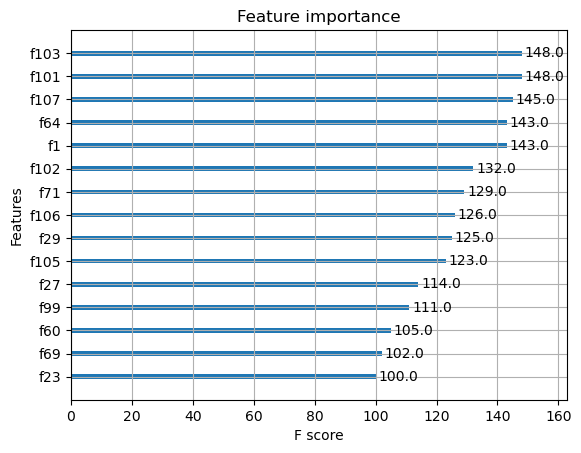

<Figure size 1600x1200 with 0 Axes>

In [7]:
xgb.plot_importance(clf, max_num_features=15)
plt.figure(figsize = (16, 12))
plt.show()

In [8]:

param_list = {
    "booster": ["gbtree", "dart"],
    "eta": [x for x in np.linspace(0.01,0.2,num=int(0.2/0.01))],
    "gamma": [x for x in np.linspace(0,2,num=5)],
    "max_depth": [3,6,8,10],
    "min_child_weight": [x for x in np.linspace(1,8,num=8)],
    "subsample": [x for x in np.linspace(0.5,1,num=5)],
    "reg_lambda": [x for x in np.linspace(0.5,10,num=10)],
    "objective": ["multi:softmax", "multi:softprob"],
    "eval_metric": ["merror", "mlogloss"]
             }

grid_xgboost = RandomizedSearchCV(XGBClassifier(nthread=-1),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=300)
grid_xgboost.fit(X_train, y_train)


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=3, random_state=0),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           im...
                                        'gamma': [0.0, 0.5, 1.0, 1.5, 2.0],
                                        'max_depth': [3, 6, 8, 10],
                                     

In [9]:
grid_xgboost.best_params_

{'subsample': 0.75,
 'reg_lambda': 7.888888888888889,
 'objective': 'multi:softmax',
 'min_child_weight': 3.0,
 'max_depth': 6,
 'gamma': 0.0,
 'eval_metric': 'mlogloss',
 'eta': 0.19,
 'booster': 'gbtree'}

Best params model complete (only OD): {'subsample': 0.875,
 'reg_lambda': 0.5,
 'objective': 'multi:softmax',
 'min_child_weight': 4.0,
 'max_depth': 8,
 'gamma': 0.5,
 'eval_metric': 'mlogloss',
 'eta': 0.12,
 'booster': 'dart'}

Best params model with FS and OD: {'subsample': 0.75,
 'reg_lambda': 7.888888888888889,
 'objective': 'multi:softmax',
 'min_child_weight': 3.0,
 'max_depth': 6,
 'gamma': 0.0,
 'eval_metric': 'mlogloss',
 'eta': 0.19,
 'booster': 'gbtree'}

In [11]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [26]:
clf = XGBClassifier(objective='multi:softmax',
                    booster="gbtree",
                    max_depth = 6,
                    gamma = 0,
                    eta=0.19,
                    reg_lambda = 7.9,
                    min_child_weight=3,
                    random_state=42,
                    nthread=-1,
                    subsample=0.75,
                    eval_metric="mlogloss",
                    n_estimators=500,
                    early_stopping_rounds=10
                   )
clf.fit(X_train, y_train, eval_set=eval_set)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:2.00253	validation_1-mlogloss:2.00865
[1]	validation_0-mlogloss:1.93623	validation_1-mlogloss:1.95160
[2]	validation_0-mlogloss:1.87540	validation_1-mlogloss:1.89466
[3]	validation_0-mlogloss:1.82381	validation_1-mlogloss:1.84489
[4]	validation_0-mlogloss:1.78185	validation_1-mlogloss:1.80555
[5]	validation_0-mlogloss:1.74146	validation_1-mlogloss:1.77321
[6]	validation_0-mlogloss:1.70985	validation_1-mlogloss:1.74513
[7]	validation_0-mlogloss:1.68176	validation_1-mlogloss:1.72116
[8]	validation_0-mlogloss:1.64894	validation_1-mlogloss:1.69265
[9]	validation_0-mlogloss:1.62241	validation_1-mlogloss:1.67085
[10]	validation_0-mlogloss:1.59879	validation_1-mlogloss:1.64957
[11]	validation_0-mlogloss:1.57519	validation_1-mlogloss:1.62759
[12]	validation_0-mlogloss:1.55535	validation_1-mlogloss:1.61337
[13]	validation_0-mlogloss:1.53732	validation_1-mlogloss:1.60498
[14]	validation_0-mlogloss:1.51770	validation_1-mlogloss:1.59091
[15]	validation_0-mlogloss:1.50192	

In [27]:
results = clf.evals_result_
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

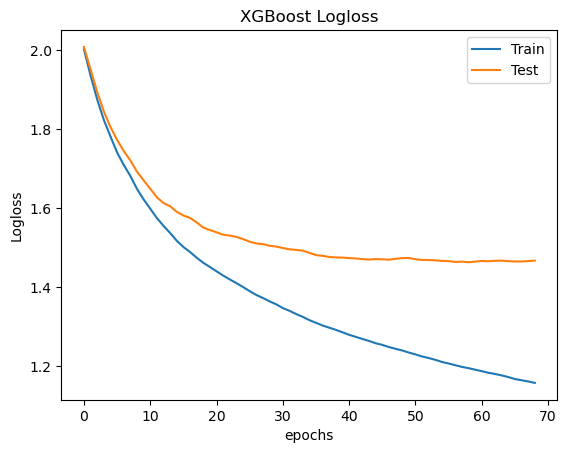

In [28]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Logloss')
plt.xlabel("epochs")
plt.title('XGBoost Logloss')
plt.show()

In [ ]:
'''
param_list = {
    "booster": ["dart"],
    "eta": [0.12],
    "gamma": [x for x in np.linspace(0,0.5,num=100)],
    "max_depth": [3,6,8,10],
    "min_child_weight": [x for x in np.linspace(1,8,num=8)],
    "subsample": [0.875],
    "reg_lambda": [x for x in np.linspace(0,0.5,num=100)],
    "objective": ["multi:softmax", "multi:softprob"],
    "eval_metric": ["mlogloss"]
             }

grid_xgboost = RandomizedSearchCV(XGBClassifier(nthread=-1),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=300,
                    verbose=4)
grid_xgboost.fit(X_train, y_train)
'''

Fitting 15 folds for each of 300 candidates, totalling 4500 fits


In [ ]:
#grid_xgboost.best_params_

{'subsample': 0.875,
 'reg_lambda': 0.030303030303030304,
 'objective': 'multi:softprob',
 'min_child_weight': 4.0,
 'max_depth': 10,
 'gamma': 0.16161616161616163,
 'eval_metric': 'mlogloss',
 'eta': 0.12,
 'booster': 'dart'}

New best params: {'subsample': 0.875,
 'reg_lambda': 0.030303030303030304,
 'objective': 'multi:softprob',
 'min_child_weight': 4.0,
 'max_depth': 10,
 'gamma': 0.16161616161616163,
 'eval_metric': 'mlogloss',
 'eta': 0.12,
 'booster': 'dart'}

In [ ]:
clf = XGBClassifier(objective='multi:softprob',
                    booster="dart",
                    max_depth = 10,
                    gamma = 0.16161616161616163,
                    eta=0.12,
                    reg_lambda = 0.030303030303030304,
                    min_child_weight=4,
                    random_state=42,
                    nthread=-1,
                    subsample=0.875,
                    eval_metric="mlogloss",
                    early_stopping_rounds=10
                   )
clf.fit(X_train, y_train, eval_set=eval_set)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:1.86001	validation_1-mlogloss:1.97455
[1]	validation_0-mlogloss:1.67741	validation_1-mlogloss:1.88408
[2]	validation_0-mlogloss:1.52416	validation_1-mlogloss:1.82645
[3]	validation_0-mlogloss:1.39189	validation_1-mlogloss:1.77270
[4]	validation_0-mlogloss:1.27117	validation_1-mlogloss:1.71806
[5]	validation_0-mlogloss:1.16630	validation_1-mlogloss:1.68126
[6]	validation_0-mlogloss:1.07217	validation_1-mlogloss:1.65355
[7]	validation_0-mlogloss:0.98823	validation_1-mlogloss:1.62354
[8]	validation_0-mlogloss:0.91143	validation_1-mlogloss:1.59535
[9]	validation_0-mlogloss:0.84406	validation_1-mlogloss:1.57021
[10]	validation_0-mlogloss:0.78108	validation_1-mlogloss:1.54770
[11]	validation_0-mlogloss:0.72568	validation_1-mlogloss:1.53147
[12]	validation_0-mlogloss:0.67215	validation_1-mlogloss:1.51313
[13]	validation_0-mlogloss:0.62710	validation_1-mlogloss:1.49919
[14]	validation_0-mlogloss:0.58603	validation_1-mlogloss:1.48833
[15]	validation_0-mlogloss:0.54713	

In [ ]:
results = clf.evals_result_
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

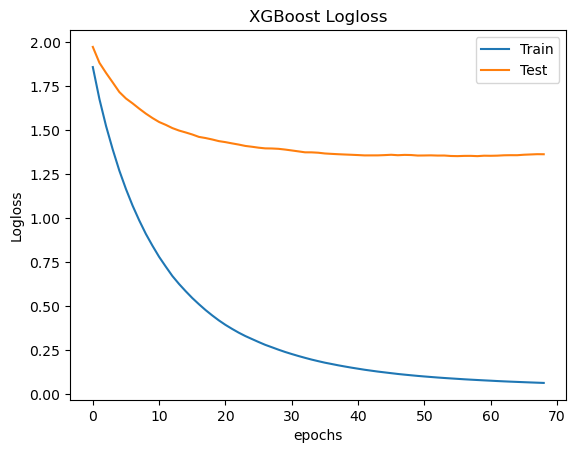

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Logloss')
plt.xlabel("epochs")
plt.title('XGBoost Logloss')
plt.show()